# UST-Net
## Written by Zhiru Yang

## import

In [1]:
import time
import tensorflow as tf
from numpy.random import seed
seed(1)
import random 
random.seed(1)
from tensorflow import random
random.set_seed(1)
from GroupNorm import GroupNormalization as GN
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import layers,Model,regularizers,constraints
from scipy import io as sio
import numpy as np
import os
import swinT
from utils import (
    PlotWhileTraining,
    load_HSI,
    plotEndmembersAndGT, 
    plotAbundancesSimple,
    plotEndmembers,
    )
from einops import rearrange
from tensorflow.keras.layers import (
    Conv2D,
    concatenate,
    MaxPooling2D,
    UpSampling2D,
    LeakyReLU,
    Dense
)
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Loss function

In [3]:
def SAD_RMSE(y_true, y_pred):
    A = -tf.keras.losses.cosine_similarity(y_true,y_pred)
    sad = tf.math.acos(A)
    rmse= tf.keras.losses.mse(y_true,y_pred) 
    return sad+rmse

In [4]:
def array(x):
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        x= sess.run(x)
    return x

## Class Sum ToOne

In [5]:
class SumToOne(layers.Layer):
    def __init__(self, params, **kwargs):
        super(SumToOne, self).__init__(**kwargs)
        self.params = params
    
    def call(self, x):
        x = tf.nn.softmax(self.params['scale']*x)
        return x

## Class Encoder

In [6]:
class Encoder(Model):
    def __init__(self, params):
        super(Encoder, self).__init__()
        self.params = params
        self.hidden_layer1= swinT.SwinT(depths=[2],num_heads=[self.params['heads']],window_size=4)
        self.pool=MaxPooling2D((2, 2), strides=(2, 2))
        self.up=UpSampling2D(size=(2, 2),interpolation='bilinear')
        self.asc=SumToOne(params=self.params)
        
    def call(self, input_patch):
        code1= Conv2D(self.params['low_dim'],1,1,use_bias=False)(input_patch)
        # Downsampling 1
        pool1 = self.pool(code1)
        code2=self.hidden_layer1(pool1)
        code2 = GN(groups=self.params['heads'], scale=False, center=False)(code2)
        code2 = tf.keras.layers.Dropout(0.2)(code2)
        code2=LeakyReLU()(code2)
        # Downsampling 2
        pool2 = self.pool(code2)
        code3=self.hidden_layer1(pool2)
        code3 = GN(groups=self.params['heads'], scale=False, center=False)(code3)
        code3 = tf.keras.layers.Dropout(0.2)(code3)
        code3=LeakyReLU()(code3)
        # Downsampling 3
        pool3 = self.pool(code3)
        code4=self.hidden_layer1(pool3)
        code4 = GN(groups=self.params['heads'], scale=False, center=False)(code4)
        code4 = tf.keras.layers.Dropout(0.2)(code4)
        code4=LeakyReLU()(code4)
        
        # Upsampling 1
        up1 = concatenate([self.up(code4), code3], axis=3)
        code5=self.hidden_layer1(up1)
        code5 = GN(groups=self.params['heads'], scale=False, center=False)(code5)
        code5 = tf.keras.layers.Dropout(0.2)(code5)
        code5=LeakyReLU()(code5)
        # Upsampling 2
        up2 = concatenate([self.up(code5), code2], axis=3)
        code6=self.hidden_layer1(up2)
        code6 = GN(groups=self.params['heads'], scale=False, center=False)(code6)
        code6 = tf.keras.layers.Dropout(0.2)(code6)
        code6=LeakyReLU()(code6)
        # Upsampling 3
        up3 = concatenate([self.up(code6), code1], axis=3)
        code7=self.hidden_layer1(up3)
        code7 = GN(groups=self.params['heads'], scale=False, center=False)(code7)
        code7 = tf.keras.layers.Dropout(0.2)(code7)
        code7=LeakyReLU()(code7)        
        
        code8=Conv2D(self.params['num_endmembers'],1,1,use_bias=False)(code7)
        code8=self.asc(code8)
        return code8

## Class Decoder


In [7]:
class Decoder(layers.Layer):
    def __init__(self, params):
        super(Decoder, self).__init__()
        self.params=params
        self.output_layer= tf.keras.layers.Dense(units=params["data"].array(0).shape[1],
                                                 kernel_regularizer=None,
                                                 activation='linear',
                                                 name="endmembers",
                                                 kernel_constraint=tf.keras.constraints.non_neg(),
                                                 use_bias=False)
    def call(self, code):   
        B, H, W, C = code.shape
        code = tf.reshape(code, [-1, H * W, C])
        recon = self.output_layer(code)
        recon = tf.reshape(recon, [-1, H, W, self.params["data"].array(0).shape[1]])
        return recon
    
    def getEndmembers(self):
        w=self.output_layer.get_weights()[0]
        return w


## Recover image

In [8]:
def recover_image(hsi,abundance_predict):
    image=hsi.image
    h,w,c=image.shape
    abundance_recover=abundance_predict[0:h,0:w,:]
    return abundance_recover

## Class Autoencoder

In [9]:
class Autoencoder(object):
    def __init__(self, patches,params):
        self.data = params["data"].image_pad
        self.encoder = Encoder(params)
        self.params = params
        self.decoder = Decoder(params)
        self.H=patches.shape[1]
        self.W=patches.shape[2]
        self.model=self.create_model()
        self.model.compile(optimizer=self.params["optimizer"], loss=self.params["loss"])
        
    def create_model(self):
        input_a = tf.keras.layers.Input(shape=(self.H,self.W,self.params["data"].array(0).shape[1],))
        abunds = self.encoder(input_a)
        output = self.decoder(abunds)
        return Model(inputs=input_a, outputs=output)
    def get_endmembers(self):
        endmembers = self.decoder.getEndmembers() 
        return endmembers

    def get_abundances(self):  
        abundances=np.squeeze(self.encoder.predict(np.expand_dims(self.data, 0)))
        abundances=recover_image(self.params["data"],abundances) 
        return abundances
        
    def fit(self, patches):
        plot_callback = PlotWhileTraining(0,self.params['data'])
        y=self.model.fit(
            x=patches, y=patches, 
            epochs=self.params['epochs'], 
            batch_size=self.params['batch_size'],
            callbacks=[plot_callback],
            verbose=1
        )
        # Plot loss pictures for training epochs
        loss_values = y.history['loss']
        fig = plt.figure()
        rect = fig.patch
        rect.set_facecolor('white')
        plt.plot(range(1, len(loss_values)+1), loss_values, 'b-')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        plt.show()
   
        return y

## Set hyperparameters

In [10]:
datasetnames = {
    "Samson": "Samson",
    "Jasper":"Jasper",
    "sy30":"sy30"
}

dataset= "Samson"
# Hyperparameters
hsi = load_HSI(
    "./Datasets/" + datasetnames[dataset] + ".mat"
)

# Hyperparameters
batch_size = 1
heads=6
ds=6
learning_rate = 0.001
epochs =100
scale =1
loss=SAD_RMSE
opt= tf.optimizers.RMSprop(learning_rate=learning_rate, decay=0.000)

## Train

Train on 10 samples
10/10 [==============================] - 4s 136ms/sample - loss: 0.9029


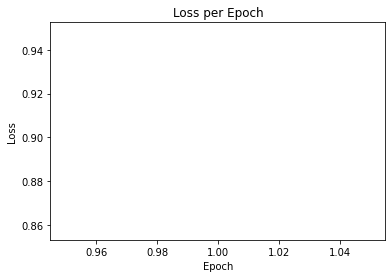

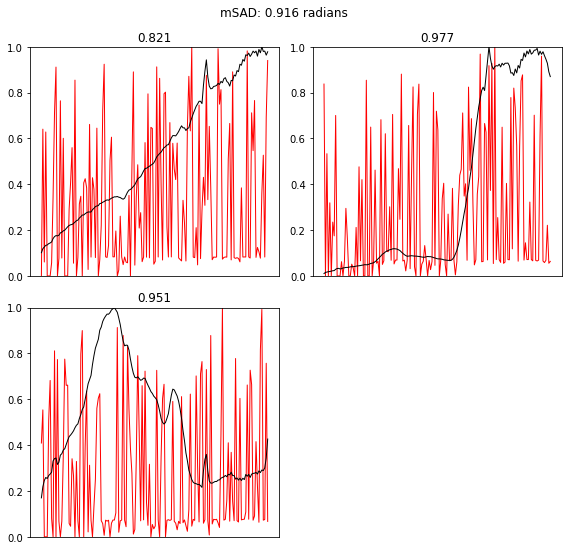

cpu_time:9.394211292266846


In [11]:
results_folder = '\Results'
method_name = 'UST-Net'

results_folder = './Results'
params = {
    "heads":heads,
    "low_dim":ds,
    "scale":scale,
    "batch_size": batch_size,
    "data": hsi,
    "epochs": epochs,
    "n_bands": hsi.bands,
    "GT": hsi.gt,
    "lr": learning_rate,
    "optimizer": opt,
    "loss": loss,
    "num_endmembers":hsi.p
    }

save_folder = results_folder+'/'+method_name+'/'+dataset
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
for run in range(1): 
    
    training_data = list()
    for i in range(0, 10):
        training_data.append(hsi.image_pad[np.newaxis, :])
    training_data = np.concatenate(training_data, axis=0)
    
    save_folder = results_folder+'/'+method_name+'/'+dataset
    save_name = dataset+'_run'+str(ds)+'.mat'
    save_path = save_folder+'/'+save_name
    start = time.time()
    autoencoder = Autoencoder(training_data,params)
    autoencoder.fit(training_data)
    endmembers = autoencoder.get_endmembers()
    abundances = autoencoder.get_abundances() 
    end = time.time()
    plotEndmembersAndGT(endmembers, hsi.gt)
    sio.savemat(save_path,{'A':endmembers,'S':abundances})
    cpu_time = end - start
    print('cpu_time:{}'.format(cpu_time))
    del autoencoder